In [1]:
path_preimages = "/Users/sakshisharma/Desktop/Mexico/Image/Pre-disaster"
path_postimages = "/Users/sakshisharma/Desktop/Mexico/Image/Post-disaster"
path_mbi_features = "/Users/sakshisharma/Desktop/Mexico/Feature/MBI"
NPY_files = "/Users/sakshisharma/Desktop/Mexico/Processed_NPY"
path_labels = "/Users/sakshisharma/Desktop/Mexico/Label"

In [ ]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from PIL import Image
import math

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


In [85]:
import numpy as np
import os
import tifffile as tiff

label_path = "/Users/sakshisharma/Desktop/Mexico/Label"
label_tif_files = [f for f in os.listdir(label_path) if f.endswith('.tif')]

all_classes = set()

for fname in label_tif_files:
    label = tiff.imread(os.path.join(label_path, fname))
    if label.ndim == 3:
        label = label.squeeze()

    unique_vals = np.unique(label)
    all_classes.update(unique_vals)

print("Unique classes in label data:", sorted(all_classes))


Unique classes in label data: [np.int8(0), np.int8(1), np.int8(2)]


Total pixel count per class


In [86]:
from collections import Counter

label_counts = Counter()

for file_name in os.listdir(path_labels):
    if not file_name.endswith('.tif'):
        continue
    label = tiff.imread(os.path.join(path_labels, file_name))
    unique, counts = np.unique(label, return_counts=True)
    label_counts.update(dict(zip(unique, counts)))

print("Total pixel count per class:")
for label, count in sorted(label_counts.items()):
    print(f"Class {label}: {count} pixels")


Total pixel count per class:
Class 0: 134504993 pixels
Class 1: 55197802 pixels
Class 2: 89461 pixels


| Class | Description           | Pixel Count     |
| ----- | --------------------- | --------------- |
| 0     | No damage             | **134,504,993** |
| 1     | Minor/Moderate damage | **55,197,802**  |
| 2     | Major damage          | **89,461**      |


In [ ]:
import os
import numpy as np
import tifffile as tiff
from tensorflow.keras.utils import Sequence

class EarthquakeDamageGenerator(Sequence):
    def __init__(self, input_files, input_path, label_path, batch_size=8, shuffle=True):
        self.input_files = input_files
        self.input_path = input_path
        self.label_path = label_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self): # this is to return the number of batches per epoch
        return int(np.ceil(len(self.input_files) / self.batch_size))

    def __getitem__(self, index): # this function is to fetch and return the input and label data for the batch  to the given index.
        batch_files = self.input_files[index * self.batch_size: (index + 1) * self.batch_size]
        return self.__data_generation(batch_files)

    def on_epoch_end(self): # randonly shuffles the input files after every epoch if shuffle is made true
        if self.shuffle:
            np.random.shuffle(self.input_files)

    def __data_generation(self, batch_files):
        X_batch, Y_batch = [], []

        for file in batch_files:
            try:
                base = file.replace("_input.npy", "") # gets label filename by removing _input.npy
            
                input_array = np.load(os.path.join(self.input_path, file), allow_pickle=True) # helps to load the input array from the npy file
                label_array = tiff.imread(os.path.join(self.label_path, base + ".tif")) # Loads the label array from the tif file

                if label_array.ndim == 3: #If label is 3D (e.g., 1x512x512), squeeze to 2D
                    label_array = label_array.squeeze()
                if label_array.shape != (512, 512):  # Only accept labels of shape (512, 512) otherwise skips that sample
                    continue 
                X_batch.append(input_array)  # Append to batch lists
                Y_batch.append(label_array.astype(np.uint8))

            except Exception as e: # Skip files that can't be read or processed and continues
                continue

        return np.array(X_batch), np.array(Y_batch)
        #so this function basically return numpy input array and numpy label array


In [15]:

from tensorflow.keras import layers, models

def convulational_block(input_tensor, number_filters): 
    # inputs are tensors coming from outside into this block
    con_blk1 = layers.Conv2D(number_filters, 3, padding = "same", activation = "relu")(input_tensor)
   # Conv2D then ReLU activation
    con_blk2 = layers.Conv2D(number_filters, 3, padding = "same", activation = "relu",)(con_blk1)
    return con_blk2

def encoder_block(input_tensor, number_filters):
    encoder_features = convulational_block(input_tensor, number_filters)
    pooling_features = layers.MaxPool2D(2)(encoder_features)
    return encoder_features, pooling_features

def bottleneck_block(input_tensor, number_filters):
    bottleneck_features = convulational_block(input_tensor, number_filters)
    return bottleneck_features

def decoder_block(x, conv_features, number_filters):
   upsample = layers.UpSampling2D(size=(2, 2))(x)
   concat = layers.Concatenate()([upsample, conv_features])
   x = convulational_block(concat, number_filters)
   return x   

def unet_model(input_shape=(512, 512, 10), num_classes=3):
    inputs = layers.Input(shape = input_shape)

    encoder_1, pooling_1 = encoder_block(inputs, 64)
    encoder_2, pooling_2 = encoder_block(pooling_1, 128)
    encoder_3, pooling_3 = encoder_block(pooling_2, 256)
    encoder_4, pooling_4 = encoder_block(pooling_3, 512)

    bottleneck = bottleneck_block(pooling_4, 1024)

    decoder_1 = decoder_block(bottleneck, encoder_4, 512)
    decoder_2 = decoder_block(decoder_1, encoder_3, 256)
    decoder_3 = decoder_block(decoder_2, encoder_2, 128)
    decoder_4 = decoder_block(decoder_3, encoder_1, 64)

    outputs = layers.Conv2D(num_classes, kernel_size=1, activation='softmax')(decoder_4)
    
    return models.Model(inputs=inputs, outputs=outputs)

model = unet_model()
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 512, 512,  │      5,824 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 512, 512,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 256, 256,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 256, 256,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 128, 128,  │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 64, 64,    │          0 │ conv2d_28[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64,    │          0 │ up_sampling2d_4[

 Total params: 31,383,107 (119.72 MB)

 Trainable params: 31,383,107 (119.72 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model = unet_model(input_shape=(512, 512, 10), num_classes=3)
model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

callbacks = [
    ModelCheckpoint("best_unet_model.keras", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]


Dataset splitting-> https://datascience.stackexchange.com/questions/67489/how-to-split-data-into-3-parts-in-python-training70-validation15-and-te

In [20]:
from sklearn.model_selection import train_test_split
import os

input_path = "/Users/sakshisharma/Desktop/Mexico/Processed_NPY"
label_path = "/Users/sakshisharma/Desktop/Mexico/Label"
all_files = sorted([f for f in os.listdir(input_path) if f.endswith("_input.npy")])

# this is for Splitting into 70% train and 30%
train_files, temp = train_test_split(all_files, test_size=0.30, random_state=42)
#here the 30% gets further divided into 15% to both val and test

val_files, test_files = train_test_split(temp, test_size=0.5, random_state=42) 
train_gen = EarthquakeDamageGenerator(train_files, input_path, label_path, batch_size=4)
val_gen = EarthquakeDamageGenerator(val_files, input_path, label_path, batch_size=4)
test_gen = EarthquakeDamageGenerator(test_files, input_path, label_path, batch_size=4)


In [21]:
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

Train files: 506
Validation files: 109
Test files: 109


In [22]:
path_preimages = "/Users/sakshisharma/Desktop/Mexico/Image/Pre-disaster"
path_postimages = "/Users/sakshisharma/Desktop/Mexico/Image/Post-disaster"
path_mbi_features = "/Users/sakshisharma/Desktop/Mexico/Feature/MBI"
NPY_files = "/Users/sakshisharma/Desktop/Mexico/Processed_NPY"
path_labels = "/Users/sakshisharma/Desktop/Mexico/Label"

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [26]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[SparseCategoricalAccuracy()]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_unet_model.h5", monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


# Save history
with open("training_history.json", "w") as f:
    json.dump(history.history, f)



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 45s/step - loss: 144.1863 - sparse_categorical_accuracy: 0.6071      

127/127 ━━━━━━━━━━━━━━━━━━━━ 6211s 49s/step - loss: 143.2965 - sparse_categorical_accuracy: 0.6076 - val_loss: 0.4856 - val_sparse_categorical_accuracy: 0.7798
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 55s/step - loss: 0.4685 - sparse_categorical_accuracy: 0.7969     

127/127 ━━━━━━━━━━━━━━━━━━━━ 7556s 59s/step - loss: 0.4686 - sparse_categorical_accuracy: 0.7968 - val_loss: 0.4488 - val_sparse_categorical_accuracy: 0.8062
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - loss: 0.4536 - sparse_categorical_accuracy: 0.8045     

127/127 ━━━━━━━━━━━━━━━━━━━━ 6007s 47s/step - loss: 0.4536 - sparse_categorical_accuracy: 0.8044 - val_loss: 0.4410 - val_sparse_categorical_accuracy: 0.8140
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 46s/step - loss: 0.4301 - sparse_categorical_accuracy: 0.8178     

127/127 ━━━━━━━━━━━━━━━━━━━━ 6351s 50s/step - loss: 0.4301 - sparse_categorical_accuracy: 0.8177 - val_loss: 0.4234 - val_sparse_categorical_accuracy: 0.8204
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - loss: 0.4365 - sparse_categorical_accuracy: 0.8136     

127/127 ━━━━━━━━━━━━━━━━━━━━ 7097s 56s/step - loss: 0.4364 - sparse_categorical_accuracy: 0.8136 - val_loss: 0.4125 - val_sparse_categorical_accuracy: 0.8276
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 65s/step - loss: 0.4114 - sparse_categorical_accuracy: 0.8272     

127/127 ━━━━━━━━━━━━━━━━━━━━ 8725s 69s/step - loss: 0.4113 - sparse_categorical_accuracy: 0.8272 - val_loss: 0.3876 - val_sparse_categorical_accuracy: 0.8346
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 42s/step - loss: 0.3694 - sparse_categorical_accuracy: 0.8459     

127/127 ━━━━━━━━━━━━━━━━━━━━ 5977s 47s/step - loss: 0.3695 - sparse_categorical_accuracy: 0.8459 - val_loss: 0.3646 - val_sparse_categorical_accuracy: 0.8421
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 41s/step - loss: 0.3811 - sparse_categorical_accuracy: 0.8383     

127/127 ━━━━━━━━━━━━━━━━━━━━ 5995s 47s/step - loss: 0.3810 - sparse_categorical_accuracy: 0.8383 - val_loss: 0.3525 - val_sparse_categorical_accuracy: 0.8478
Epoch 9/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - loss: 0.3658 - sparse_categorical_accuracy: 0.8392     

127/127 ━━━━━━━━━━━━━━━━━━━━ 5623s 44s/step - loss: 0.3657 - sparse_categorical_accuracy: 0.8392 - val_loss: 0.3460 - val_sparse_categorical_accuracy: 0.8513
Epoch 10/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 37s/step - loss: 0.3509 - sparse_categorical_accuracy: 0.8486     

127/127 ━━━━━━━━━━━━━━━━━━━━ 5220s 41s/step - loss: 0.3509 - sparse_categorical_accuracy: 0.8486 - val_loss: 0.3368 - val_sparse_categorical_accuracy: 0.8548


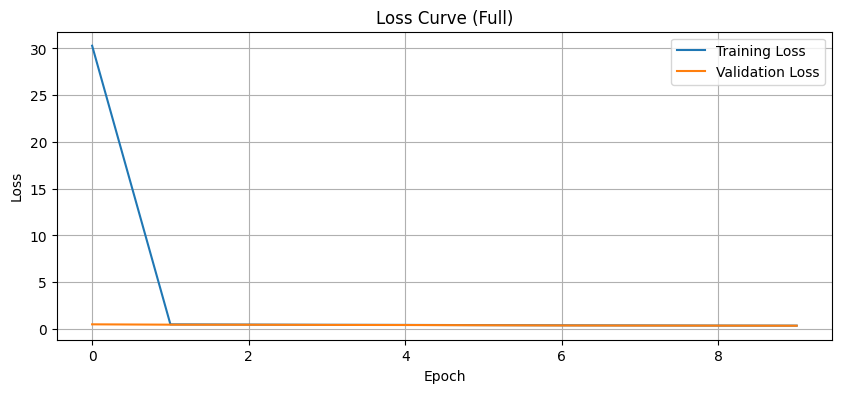

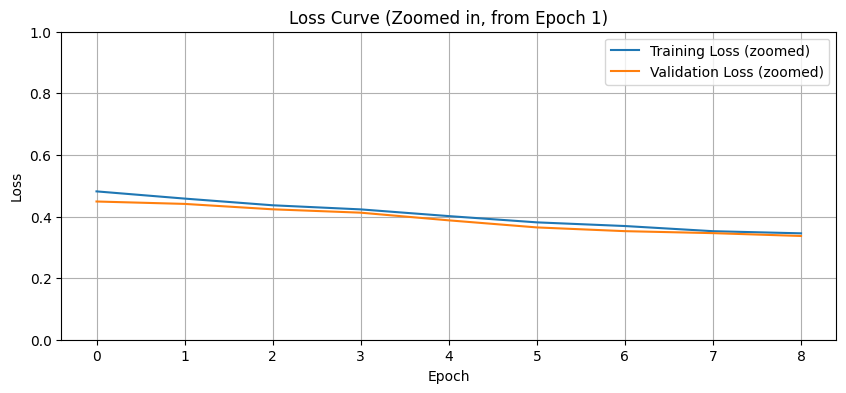

In [ ]:
# Graph 1 for the full loss curve
plt.figure(figsize = (10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Full)")
plt.legend()
plt.grid(True)
plt.show()

# Graph 2 for zoomed-in loss curve as the drop from epoch 1 to 2 is huge
plt.figure(figsize = (10, 4))
plt.plot(history.history['loss'][1:], label='Training Loss (zoomed)')
plt.plot(history.history['val_loss'][1:], label='Validation Loss (zoomed)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (Zoomed in, from Epoch 1)")
plt.ylim(0, 1) 
plt.legend()
plt.grid(True)
plt.show()


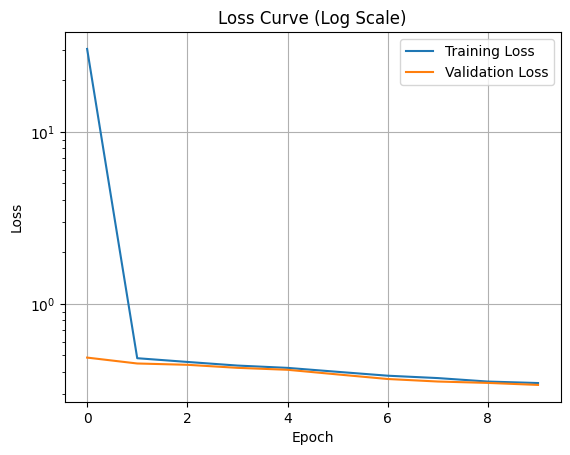

In [28]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss Curve (Log Scale)")
plt.legend()
plt.grid(True)
plt.show()

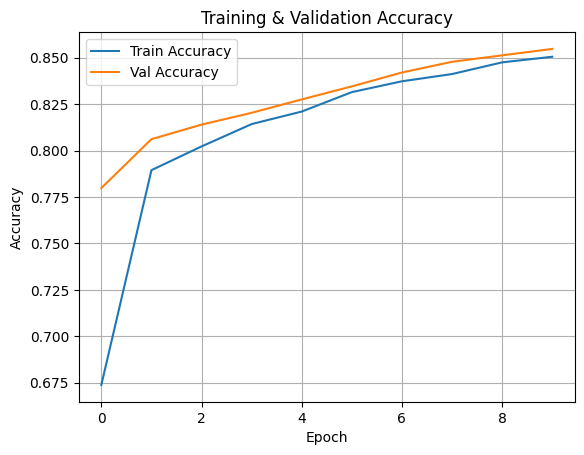

In [29]:
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


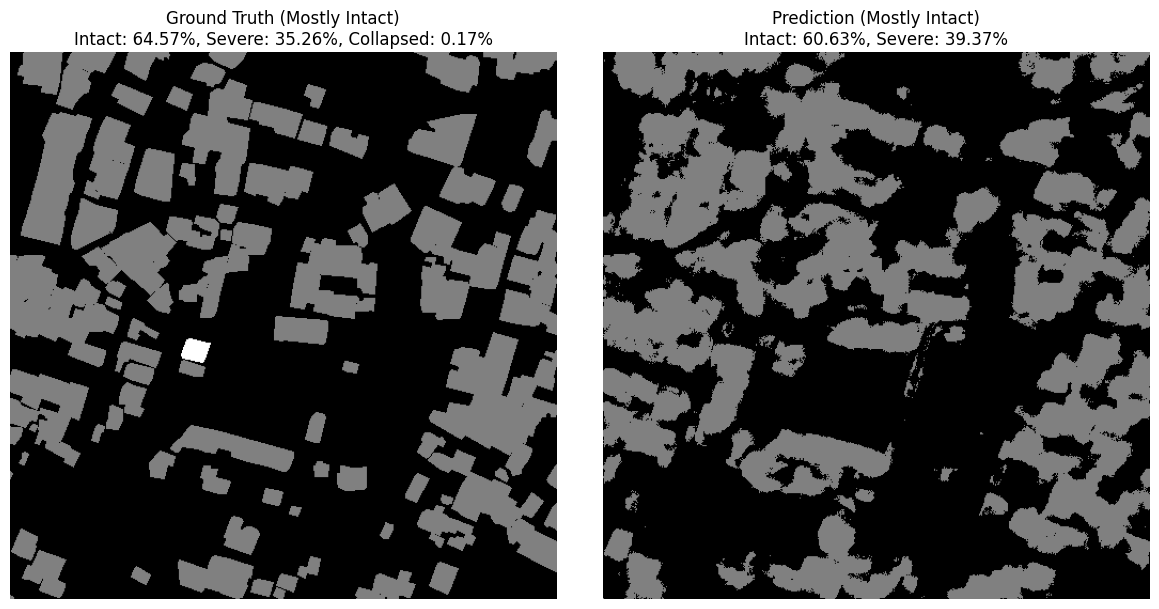

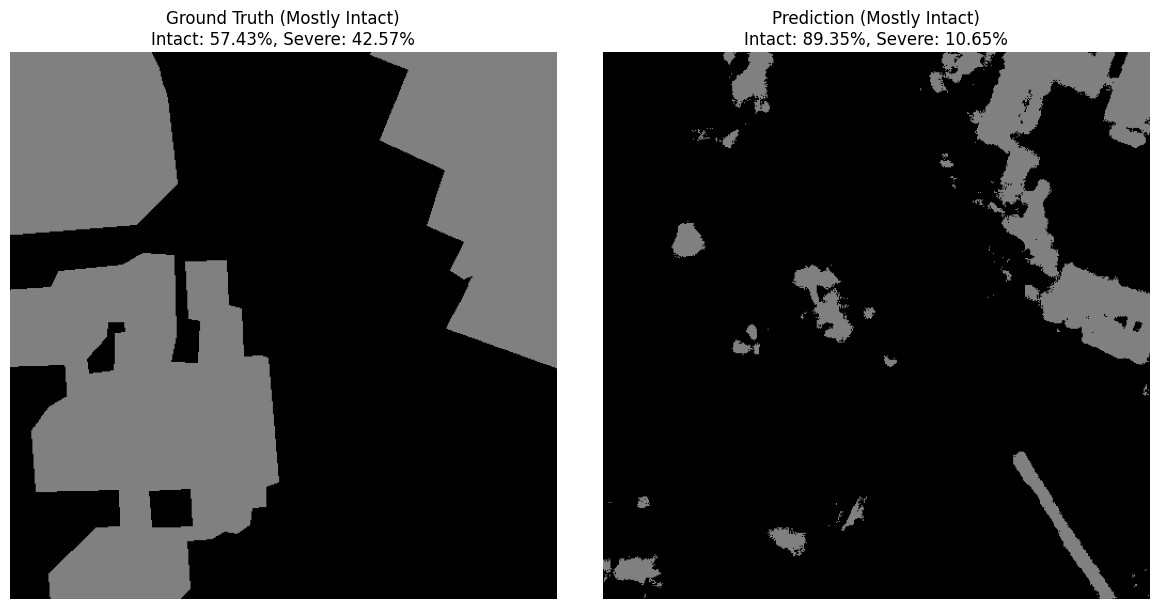

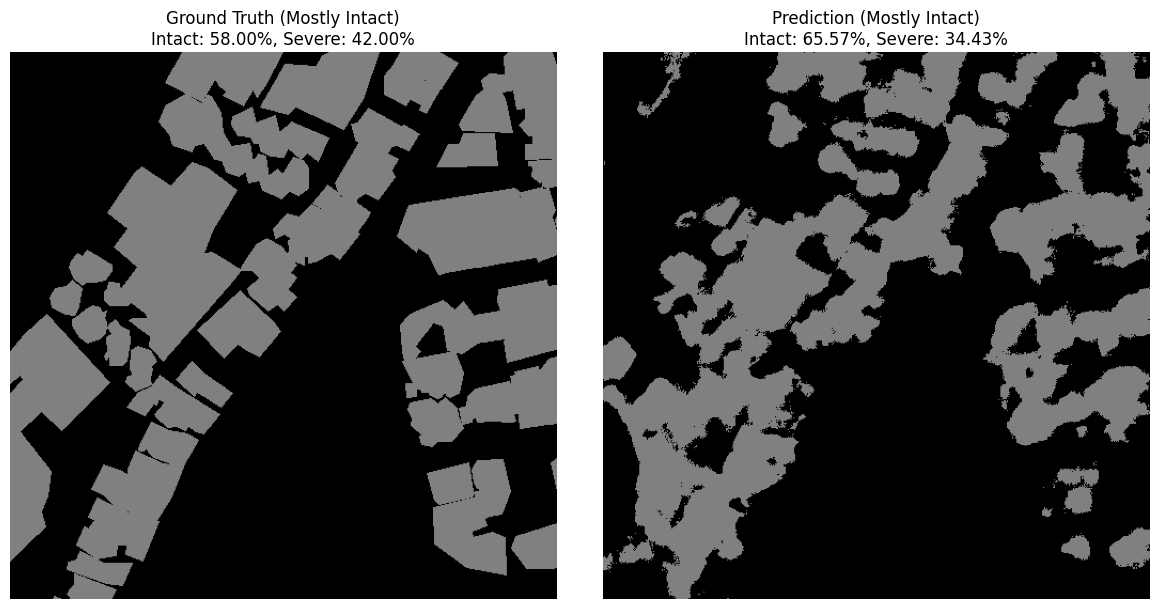

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Label colors (RGB)
label_colors = {
    0: [0, 0, 0],          # this refers to intact, that is black
    1: [128, 128, 128],    # this refers to severe, that is gray
    2: [255, 255, 255]     # this refers to collapsed, that is white
}

# Label names
label_names = {
    0: "Intact",
    1: "Severe",
    2: "Collapsed"
}

def changing_mask_rgb(label_mask, color_map):
    height, width = label_mask.shape  # for getting the height and width of the 2D label mask
    rgb_img = np.zeros((height, width, 3), dtype=np.uint8)  # Creates an empty RGB image of the same height and width
    for label, color in color_map.items(): # this is for looping  through each label and its assigned color
        rgb_img[label_mask == label] = color  # to replacd all pixels with the current label by its corrct rgb colour
    return rgb_img

def get_label_percentages(mask):
    total_pixels = mask.size #get the size of the mask like height x width
    counts = Counter(mask.flatten()) #  first turns the 2D mask into a 1D list of labels and then the counter counts how many time 0,1,2 appears
    percentages = {label: (count / total_pixels) * 100 for label, count in counts.items()} # here using the count recieved from counter-> convert it into %
    most_common_label = counts.most_common(1)[0][0]
    return percentages, most_common_label #gives the label with the most pixels

def add_labelpercentage(label_percentages):
    hold_info = [] # hold info until combined 
    sorted_labels = sorted(label_percentages) #Sort labels (0,1,2)
    i = 0
    while i < len(sorted_labels):
        label_id = sorted_labels[i]
        percentage = label_percentages[label_id]
        label_name = label_names[label_id]
        hold_info.append(f"{label_name}: {percentage:.2f}%")
        i += 1
    return ", ".join(hold_info)


X_vis, y_true_vis = test_gen[2] # Loads a batch from your generator, here is batch 2 

# Predict on batch and get labels (argmax for class)
y_pred_vis = model.predict(X_vis) # predicts on batch 2 
y_pred_vis = np.argmax(y_pred_vis, axis=-1) # gets labels 


for i in range(min(3, len(X_vis))): # to not visualize too many images a loop is created to showcase only 3 images from batch 2
    true_mask = y_true_vis[i]
    pred_mask = y_pred_vis[i]

    # this is to get label percentages and most common label for true and pred masks
    true_percentages, most_common_true = get_label_percentages(true_mask)
    pred_percentages, most_common_pred = get_label_percentages(pred_mask)

    # Converting the masks to rgb img for viszualisation
    true_colored = changing_mask_rgb(true_mask, label_colors)
    pred_colored = changing_mask_rgb(pred_mask, label_colors)

    # plotting
    plt.figure(figsize=(12, 6))
# this is for showcasing ground truth image with the label names and their percentages
    plt.subplot(1, 2, 1)
    plt.imshow(true_colored)
    plt.title(
        f"Ground Truth (Mostly {label_names[most_common_true]})\n" 
        f"{add_labelpercentage(true_percentages)}"
    )
    plt.axis('off')

 # this is for showcasing ground truth image with the label names and their percentages
    plt.subplot(1, 2, 2)
    plt.imshow(pred_colored)
    plt.title(
        f"Prediction (Mostly {label_names[most_common_pred]})\n" 
        f"{add_labelpercentage(pred_percentages)}"
    )
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [123]:
has_all_three = []

for i in range(len(y_pred_vis)):
    unique_labels = np.unique(y_pred_vis[i])
    if set([0, 1, 2]).issubset(unique_labels):
        has_all_three.append(i)
        print(f"Sample {i} contains all 3 classes: {unique_labels}")

if not has_all_three:
    print(" No predicted masks contain all 3 classes.")
else:
    print(f"Total samples with all 3 classes: {len(has_all_three)} → {has_all_three}")


 No predicted masks contain all 3 classes.


In [32]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, jaccard_score

true_labels = []
pred_labels = []

max_batches = len(val_gen)  # total number of batches

for i, batch in enumerate(val_gen):
    if i >= max_batches:
        break  # stop if the batches are more than expected

    X_batch, y_true_batch = batch
    y_pred_batch = model.predict(X_batch)
    y_pred_batch = np.argmax(y_pred_batch, axis=-1)
    
    true_labels.append(y_true_batch.flatten())
    pred_labels.append(y_pred_batch.flatten())

y_true_all = np.concatenate(true_labels)
y_pred_all = np.concatenate(pred_labels)

f1 = f1_score(y_true_all, y_pred_all, average='macro')
accuracy = accuracy_score(y_true_all, y_pred_all)
iou = jaccard_score(y_true_all, y_pred_all, average='macro')

print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"IoU (Jaccard): {iou:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━

IoU: 0.4614 | F1 Score: 0.5407 | Accuracy: 0.8548

 Pixel Classification Report 
              precision    recall  f1-score   support

      Intact       0.89      0.92      0.90  20814694
      Severe       0.75      0.69      0.72   7748597
   Collapsed       0.00      0.00      0.00     10405

    accuracy                           0.85  28573696
   macro avg       0.55      0.54      0.54  28573696
weighted avg       0.85      0.85      0.85  28573696



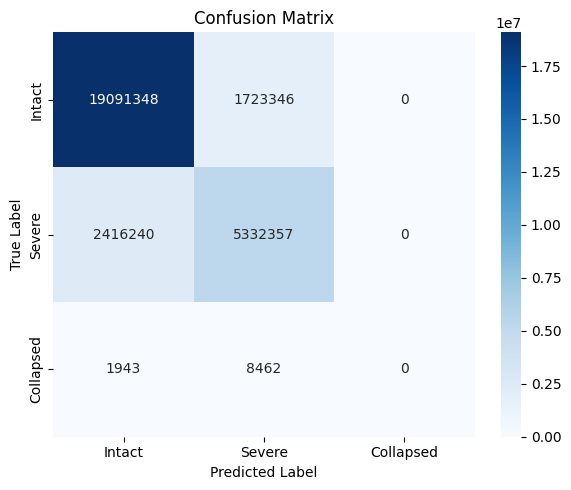

In [36]:
# Evaluation metrics
f1 = f1_score(y_true_all, y_pred_all, average='macro', zero_division=0)
accuracy = accuracy_score(y_true_all, y_pred_all)
iou = jaccard_score(y_true_all, y_pred_all, average='macro', zero_division=0)


print(f"IoU: {iou:.4f} | F1 Score: {f1:.4f} | Accuracy: {accuracy:.4f}")
print("\n Pixel Classification Report ")
print(classification_report(
    y_true_all, y_pred_all,
    target_names=["Intact", "Severe", "Collapsed"],
    zero_division=0
))

# Confusion Matrix for damage assesment 
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Intact", "Severe", "Collapsed"],
            yticklabels=["Intact", "Severe", "Collapsed"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [33]:
test_loss = model.evaluate(test_gen)
print("Test Loss:", test_loss)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 533s 19s/step - loss: 0.3407 - sparse_categorical_accuracy: 0.8550
Test Loss: [0.3452399671077728, 0.8525558710098267]


In [35]:
#finding the metrics of just one batch 
X_batch, y_batch = next(iter(val_gen))
y_pred = model.predict(X_batch, verbose=0)
y_pred = np.argmax(y_pred, axis=-1)

from sklearn.metrics import f1_score, accuracy_score, jaccard_score

y_true = y_batch.flatten()
y_pred_flat = y_pred.flatten()

print("F1 Score:", f1_score(y_true, y_pred_flat, average='macro'))
print("Accuracy:", accuracy_score(y_true, y_pred_flat))
print("IoU:", jaccard_score(y_true, y_pred_flat, average='macro'))


F1 Score: 0.8358144737288531
Accuracy: 0.93341064453125
IoU: 0.7384932372663259
